# Домашнее задание №1 - Применение методов NLP


В этом домашнем задании мы будем работать с данными из сорневнования: 
[Toxic comment classification challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)
  
  
В задании небходимо по тексту комментария определить веротяности следующих категорий:
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

Как и в соревновании мы везде будем использовать метрику ROC AUC для валидации

_Обратите внимание, что каждый комментарий может иметь несколько меток разных классов_

### Что нужно сделать? 

1. Подготовка __[10%]__:
    - Скачайте данные, проведите первоначальные EDA: баланс классов, пересечение классов и т.д. 
    

In [1]:
import pandas as pd 
import numpy as np
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [5]:
count_classes=train.iloc[:,2:].sum(axis=1)
train['clean']=(count_classes==0)
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",count_classes.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


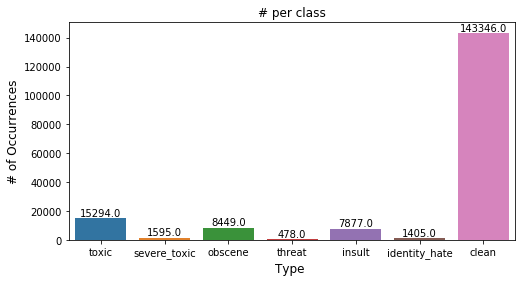

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

classes=train.iloc[:,2:].sum()
plt.figure(figsize=(8,4))
ax= sns.barplot(classes.index, classes.values)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
rects = ax.patches
labels = classes.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

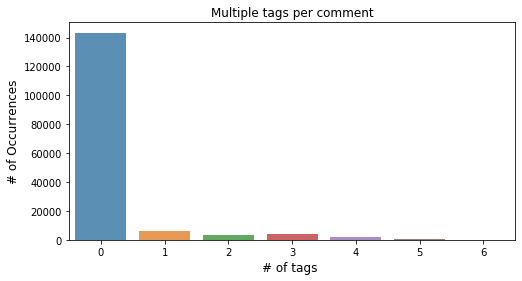

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64


In [7]:
x=count_classes.value_counts()

plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)
plt.show()
print(x)

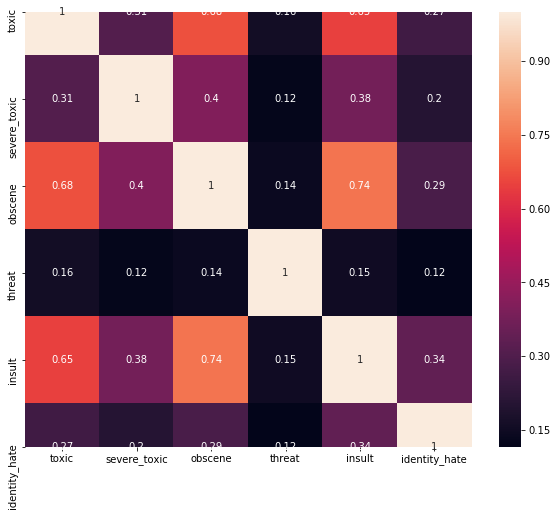

In [8]:
temp_df=train.iloc[:,2:-1]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True);

In [9]:
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    array_conf_matrix = np.array(confusion_matrix.values)
    df_conf_matrix = pd.DataFrame(array_conf_matrix)
    corr_mats.append(df_conf_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])
out.index.name = 'toxic'

out

severe_toxic       obscene        threat       insult        \
                 0     1       0     1       0    1       0     1   
toxic                                                               
0           144277     0  143754   523  144248   29  143744   533   
1            13699  1595    7368  7926   14845  449    7950  7344   

      identity_hate        
                  0     1  
toxic                      
0            144174   103  
1             13992  1302

Все очень токсичные комментарии - токсичные

## Придумайте и обоснуйте стратегию валидации.
Сделайте предбработку данных. Оцените что требуется делать с символами, заглавными буквами. Проведите лемматизацию или стеминг.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re, string
import time
from scipy.sparse import hstack, vstack

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [58]:
global a 
a = 0

In [61]:
def tokenize(s): 
    global a
    if a == 0:
        print(s)
        a = 1
    return re_tok.sub(r' \1 ', s).split()

In [22]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
subm = pd.read_csv('sample_submission.csv')

id_train = train['id'].copy()
id_test = test['id'].copy()

# add empty label for None
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)

In [49]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
tmp = "explanation why the edits made under my username hardcore metallica fan were reverted? they weren' t vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.89.205.38.27"

In [87]:
train['comment_text'][:5]

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [146]:
vec = TfidfVectorizer(ngram_range=(1,2), lowercase=True,
               min_df=4, strip_accents='unicode', use_idf=1,
                      smooth_idf=1, sublinear_tf=1)
tmp1 = vec.fit_transform(train['comment_text'][:1000])

In [147]:
# print(tmp1)

In [148]:
print(vec.get_feature_names())

['000', '04', '06', '07', '08', '09', '10', '100', '11', '12', '13', '14', '15', '16', '161', '17', '177', '18', '19', '194', '1px', '1px solid', '1st', '20', '200', '2000', '2004', '2004 utc', '2005', '2005 utc', '2006', '2006 utc', '2007', '2007 utc', '2008', '2010', '2011', '2012', '2013', '2014', '209', '20th', '21', '23', '24', '25', '27', '28', '29', '30', '31', '33', '36', '38', '3rr', '45', '50', '67', '70', '80', '81', '82', '86', '90', 'able', 'able to', 'about', 'about contributing', 'about him', 'about his', 'about it', 'about my', 'about person', 'about that', 'about the', 'about this', 'about what', 'about your', 'above', 'absolutely', 'abusing', 'academic', 'accept', 'accepted', 'accepted as', 'access', 'access to', 'according', 'according to', 'account', 'accounts', 'accurate', 'accusations', 'accused', 'accusing', 'accusing me', 'across', 'across the', 'act', 'action', 'actions', 'actual', 'actually', 'ad', 'ad hominem', 'add', 'add information', 'add the', 'added', 'a

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [46]:
print('\1')




In [172]:
# Tf-idf

# prepare tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

# create sparse matrices
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
                      smooth_idf=1, sublinear_tf=1)
train_term_doc = vec.fit_transform(train['comment_text'])
test_term_doc = vec.transform(test['comment_text'])

In [155]:
print(vec.get_feature_names()[:8000])

['00', '00 00', '00 01', '00 02', '00 03', '00 05', '00 07', '00 09', '00 10', '00 11', '00 12', '00 13', '00 14', '00 15', '00 16', '00 17', '00 18', '00 19', '00 20', '00 21', '00 22', '00 23', '00 24', '00 25', '00 26', '00 27', '00 29', '00 30', '00 31', '00 36', '00 37', '00 38', '00 39', '00 40', '00 41', '00 42', '00 43', '00 44', '00 45', '00 47', '00 49', '00 50', '00 52', '00 54', '00 56', '00 57', '00 58', '00 59', '00 am', '00 html', '00 july', '00 jun', '00 may', '00 pm', '00 utc', '00 year', '000', '000 00', '000 000', '000 and', '000 articles', '000 as', '000 build', '000 but', '000 bytes', '000 community', '000 copies', '000 died', '000 edits', '000 emails', '000 feet', '000 figure', '000 for', '000 frequently', '000 from', '000 google', '000 hello', '000 hits', '000 if', '000 in', '000 inhabitants', '000 is', '000 it', '000 jews', '000 km', '000 members', '000 men', '000 miles', '000 more', '000 new', '000 of', '000 or', '000 pages', '000 people', '000 persons', '000 r

In [193]:
# combine
ytrain = np.zeros((train_term_doc.shape[0]))
ytest = np.ones((test_term_doc.shape[0]))
# ydat = np.hstack((ytrain, ytest))

xdat = vstack([train_term_doc, test_term_doc], format='csr') # разреженная матрица

In [194]:
print(xdat.shape)

(312735, 426005)


In [205]:
nfolds = 10
seed = 42

# stratified split
skf = StratifiedKFold(n_splits=nfolds, random_state=seed)

score_vec = np.zeros((nfolds))

In [206]:
for (f, (train_index, test_index)) in enumerate(skf.split(train_term_doc, ytrain)):
    print(f)
    x_train = vstack([train_term_doc[train_index], test_term_doc], format='csr') # разреженная матрица
    y_train = np.hstack((ytrain[train_index], ytest))
#     print(x_train.shape, y_train.shape)
    
    x_pred = train_term_doc[test_index]
#     print(x_pred.shape)   

    clf = LogisticRegression()
    clf.fit(x_train, y_train)
    
    score = clf.predict_proba(x_pred)[:,1]
    for (i,j )
    

0


/Users/daniil/anaconda3/envs/Losh_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: could not broadcast input array from shape (15958) into shape (1)

In [176]:
score_vec

array([[0.8978092 ],
       [0.89616362],
       [0.89593277],
       [0.89684948],
       [0.89413951]])

In [208]:
arr1 = np.arange(10)


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [213]:
set(arr1)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

- Придумайте и обоснуйте стратегию валидации. 
    - Сделайте предбработку данных. Оцените что требуется делать с символами, заглавными буквами. Проведите лемматизацию или стеминг.
2. Примените любой Embedding (word2vec или Glove) __[5%]__
3. Постройте следующие модели (для каждой необходимо самостоятельно выбрать оптимальное количество слоеев и архитектуру, оценить качество, переобученность, построить кривые обучения и валидации, сделать выводы по примению модели):
    - Одномерные свертки __[20%]__
    - LSTM или GRU __[20%]__
    - Bidirectional LSTM __[20%]__   
4. Попробуйте применить к этой задаче BERT или GPT-2. Выбор оптимального количества слоеев и архитектура на ваш вкус (но не забудьте обосновать его). Оцените качетво и другие параметры работы модели. __[25%]__

#### Дополнительные 50%

5. Основываясь на полученных результатах, сделайте свою лучшую модель и сделайте Late Submission на тестовых данных [challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Не забудьте <u>приложить</u> скриншот с Вашим скором. Скриншот вставьте прямо в ноутбук с решением или выведите в stdout. 

  
  
______
_Правила полученения дополнительных баллов:_
- можно получить от 20% до 50% в зависимости от метрики качества других участников нашего курса полученного на лидерборде
- Чтобы получить минимум в 20% нужно: 
    - Основные задания должны быть полностью решены
    - Обосновать то решение которое отправили.
    - Предложенная модель должна отличаться от тех, что строились в заданиях 2-4
    
__ Готовый ноутбук загрузите в эту форму: [http://bit.ly/dafe_hw](http://bit.ly/dafe_hw) __

